In [13]:
!pip install langgraph
!pip install langchain_community
!pip install bert-score
!pip install unbabel-comet

^C


In [14]:
import langchain
import langgraph
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
import torch
from bert_score import score as bert_score
from comet import download_model, load_from_checkpoint
import os
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from typing import TypedDict, List
from huggingface_hub import login


In [15]:
login(token= os.getenv("HUGGING_FACE_TOKEN"))

In [ ]:
model_path = download_model("Unbabel/wmt22-cometkiwi-da")
comet_model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

c:\Users\201\miniforge3\envs\pystudy\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\201\.cache\huggingface\hub\models--Unbabel--wmt22-cometkiwi-da. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.ckpt:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/710 [00:00<?, ?B/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.2 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\201\.cache\huggingface\hub\models--Unbabel--wmt22-cometkiwi-da\snapshots\a79bfca292fc1689cbab6ef941ca6fc439f7195f\checkpoints\model.ckpt`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

c:\Users\201\miniforge3\envs\pystudy\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\201\.cache\huggingface\hub\models--microsoft--infoxlm-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/513 [00:00<?, ?B/s]

Encoder model frozen.
c:\Users\201\miniforge3\envs\pystudy\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [16]:
class State(TypedDict):
    messages: List[HumanMessage | AIMessage | SystemMessage]
    originStr: str
    translateStr: str 
    bert_score: float
    comet_score: float

In [17]:
# os.environ["OPENAI_API_KEY"] = "(발급받은 API 키)"
# OpenAI 모델 설정
llm = ChatOpenAI(model_name="gpt-4o", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"))

In [18]:
def detect_intent(state: State) -> State:
    """ 사용자의 의도를 확인하는 함수 """
    system_prompt = "Is the user asking for a translation? Answer only 'yes' or 'no'."
    user_message = state["messages"][-1].content  # 마지막 메시지의 content만 추출
    response = llm([SystemMessage(content=system_prompt), HumanMessage(content=user_message)])
    print("Intent Check Response:", response.content.strip())  # 응답 텍스트만 출력
    intent = response.content.strip().lower() == "yes"
    return {"messages": state["messages"] + [AIMessage(content=response.content)], "originStr": state["originStr"], "translateStr": state["translateStr"], "bert_score": state["bert_score"], "comet_score": state["comet_score"]}

In [19]:
def translate_text(state: State, target_language="ko") -> State:
    """ 텍스트를 번역하는 함수 """
    if "yes" in state["messages"][-1].content.lower():
        system_prompt = f"Translate the following text into {target_language}:"
        user_message = state["messages"][-2].content  # 원래 입력된 메시지
        response = llm([SystemMessage(content=system_prompt), HumanMessage(content=user_message)])
        print("Translation Response:", response.content.strip())  # 응답 텍스트만 출력
        return {"messages": state["messages"] + [AIMessage(content=response.content)], "originStr": user_message, "translateStr": response.content, "bert_score": state["bert_score"], "comet_score": state["comet_score"]}
    return state

In [20]:
def evaluate_translation(state: State) -> State:
    """ 번역 품질을 평가하는 함수 """
    source_text = state["originStr"]  # 원본 문장
    translated_text = state["translateStr"]  # 번역된 문장
    
    # BERT Score 계산
    P, R, F1 = bert_score([translated_text], [source_text], model_type="bert-base-multilingual-cased", verbose=True)
    bert_f1 = F1.mean().item()
    
    data = [{"src": source_text, "mt": translated_text}]
    comet_score = comet_model.predict(data, batch_size=1, gpus=1)["scores"][0]
    
    print("BERT Score F1:", bert_f1)
    print("COMET Score:", comet_score)
    
    return {"messages": state["messages"], "originStr": state["originStr"], "translateStr": state["translateStr"], "bert_score": bert_f1, "comet_score": comet_score}

In [21]:
def condition_intent(state: State) -> str:
    return "translate" if "yes" in state["messages"][-1].content.lower() else END

In [22]:
# LangGraph Workflow
graph_builder = StateGraph(State)
graph_builder.add_node("intent_check", detect_intent)
graph_builder.add_node("translate", translate_text)
graph_builder.add_node("evaluate", evaluate_translation)

graph_builder.add_edge(START, "intent_check")
graph_builder.add_conditional_edges("intent_check", condition_intent)
graph_builder.add_edge("translate", "evaluate")
graph_builder.add_edge("evaluate", END)
graph = graph_builder.compile()

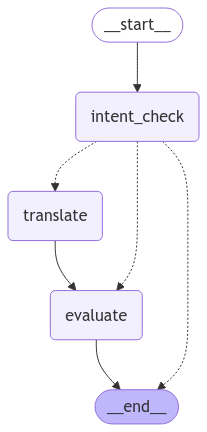

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [24]:
# 실행 예제
input_text = "다음을 영어로 번역해줄래? '간장 공장 공장장은 강 공장장이고 된장 공장 공장장은 장 공장장이다.'"
initial_state = {"messages": [HumanMessage(content=input_text)], "originStr": "", "translateStr": "", "bert_score": 0.0, "comet_score": 0.0}
result = graph.invoke(initial_state)
print("Final Result:", result["messages"][-1].content)


C:\Users\201\AppData\Local\Temp\ipykernel_17056\2589415609.py:5: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([SystemMessage(content=system_prompt), HumanMessage(content=user_message)])


Intent Check Response: yes
Translation Response: The soy sauce factory manager is Manager Kang, and the soybean paste factory manager is Manager Jang.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\Users\201\miniforge3\envs\pystudy\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\201\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.85 seconds, 1.17 sentences/sec


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


BERT Score F1: 0.6322697997093201
COMET Score: 0.7358988523483276
Final Result: The soy sauce factory manager is Manager Kang, and the soybean paste factory manager is Manager Jang.


In [25]:
result

{'messages': [HumanMessage(content="다음을 영어로 번역해줄래? '간장 공장 공장장은 강 공장장이고 된장 공장 공장장은 장 공장장이다.'", additional_kwargs={}, response_metadata={}),
  AIMessage(content='yes', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The soy sauce factory manager is Manager Kang, and the soybean paste factory manager is Manager Jang.', additional_kwargs={}, response_metadata={})],
 'originStr': "다음을 영어로 번역해줄래? '간장 공장 공장장은 강 공장장이고 된장 공장 공장장은 장 공장장이다.'",
 'translateStr': 'The soy sauce factory manager is Manager Kang, and the soybean paste factory manager is Manager Jang.',
 'bert_score': 0.6322697997093201,
 'comet_score': 0.7358988523483276}